### This notebook generates the SD-CAPE relationships for MCSs in the idealized RCE simulations. First import libraries and constants.

In [43]:
import numpy as np
from scipy import stats
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# colorblind friendly colormap
CB_color_cycle = [ '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                   '#999999', '#e41a1c', '#dede00']

## Loading RCE data

In [36]:
#path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
path = '/xdisk/sylvia/RCE-CAPE-exploration/'
ssts = np.arange( 285, 315, 5 )

mean_285 = xr.open_dataset( path + 'RCE_COL_MEAN_285.nc' )
mean_290 = xr.open_dataset( path + 'RCE_COL_MEAN_290.nc' )
mean_295 = xr.open_dataset( path + 'RCE_COL_MEAN_295.nc' )
mean_300 = xr.open_dataset( path + 'RCE_COL_MEAN_300.nc' )
mean_305 = xr.open_dataset( path + 'RCE_COL_MEAN_305.nc' )
mean_310 = xr.open_dataset( path + 'RCE_COL_MEAN_310.nc' )

p99_285 = xr.open_dataset( path + 'RCE_COL_99_285.nc' )
p99_290 = xr.open_dataset( path + 'RCE_COL_99_290.nc' )
p99_295 = xr.open_dataset( path + 'RCE_COL_99_295.nc' )
p99_300 = xr.open_dataset( path + 'RCE_COL_99_300.nc' )
p99_305 = xr.open_dataset( path + 'RCE_COL_99_305.nc' )
p99_310 = xr.open_dataset( path + 'RCE_COL_99_310.nc' )

clusters_285 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_285.nc' )
clusters_290 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_290.nc' )
clusters_295 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_295.nc' )
clusters_300 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_300.nc' )
clusters_305 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_305.nc' )
clusters_310 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_310.nc' )

### Scaling of CAPE and saturation deficit across SSTs

In [37]:
mean_RCE = [ mean_285, mean_290, mean_295, mean_300, mean_305, mean_310 ]
p99_RCE = [ p99_285, p99_290, p99_295, p99_300, p99_305, p99_310 ]

sd_bins_list = [ [] for i in np.arange( len(mean_RCE) ) ]
capemean_list = [ [] for i in np.arange( len(mean_RCE) ) ]
capeerror_list = [ [] for i in np.arange( len(mean_RCE) ) ]
cape99_list = [ [] for i in np.arange( len(p99_RCE) ) ]

In [38]:
print(mean_295['SD'].max(),mean_295['SD'].min())

<xarray.DataArray 'SD' ()>
array(2.99421144) <xarray.DataArray 'SD' ()>
array(0.17387719)


In [39]:
nbin = 40
pc2 = 99
cape_cc = np.empty( (3, len(mean_RCE)) )
sd_cc = np.empty( (2, len(mean_RCE)) )
for iterator, array in zip( np.arange(len(mean_RCE)), mean_RCE ):
    sd_RCE = array['SD'].to_numpy()
    capemean_RCE = array['CAPE'].to_numpy()

    sd_bins, capemean_vals, _, cape99_vals, _, cape_error, _, _ = \
        bin_stat_function( nbin, 0, np.nanmax(sd_RCE), sd_RCE, capemean_RCE, pc2=pc2, threshold=10 )
    #print( np.nanmin(sd_RCE), np.nanmax(sd_RCE) )
    sd_cc[0,iterator] = np.nanmean( sd_RCE )
    sd_cc[1,iterator] = np.nanmedian( sd_RCE )
    cape_cc[0,iterator] = np.nanmean( capemean_RCE )
    cape_cc[1,iterator] = np.nanmedian( capemean_RCE )
    cape_cc[2,iterator] = np.nanpercentile( capemean_RCE, 99 )
    
    sd_bins_list[iterator] = sd_bins
    capemean_list[iterator] = capemean_vals
    cape99_list[iterator] = cape99_vals
    capeerror_list[iterator] = cape_error

print( 'Scaling [% per K] of SD with SST using mean SD:' )
print( (1 - sd_cc[0,:-1]/sd_cc[0,1:])*100./5. )
print( 'Scaling [% per K] of SD with SST using median SD:' )
print( (1 - sd_cc[1,:-1]/sd_cc[1,1:])*100./5. )
print( 'Scaling [% per K] of CAPE with SST using mean CAPE:' )
print( (1 - cape_cc[0,:-1]/cape_cc[0,1:])*100./5. )
print( 'Scaling [% per K] of CAPE with SST using median CAPE:' )
print( (1 - cape_cc[1,:-1]/cape_cc[1,1:])*100./5. )
print( 'Scaling [% per K] of CAPE with SST using CAPE_99:' )
print( (1 - cape_cc[2,:-1]/cape_cc[2,1:])*100./5. )

Scaling [% per K] of SD with SST using mean SD:
[8.65209839 6.61852078 8.7081662  8.0726835  7.27999978]
Scaling [% per K] of SD with SST using median SD:
[8.5012546  6.23305087 8.18215338 8.17176619 5.91238256]
Scaling [% per K] of CAPE with SST using mean CAPE:
[5.82118627 5.54634054 7.70739176 4.91877991 5.84860708]
Scaling [% per K] of CAPE with SST using median CAPE:
[5.24212881 5.56711906 6.81095073 5.75432664 3.39347718]
Scaling [% per K] of CAPE with SST using CAPE_99:
[ 6.78055633  7.32374713 12.11072218  4.65577283  9.76999555]


### Filter the scaling of CAPE and saturation deficit at higher SSTs (300-310 K) for different MCS extents

In [40]:
clusters = [clusters_285, clusters_290, clusters_295, clusters_300, clusters_305, clusters_310]
rad = []
for c in clusters:
    rad.append( 2*(c['cluster_sizes']*9/np.pi)**(0.5) )

    
sd_RCE = np.concatenate( (mean_285['SD'].to_numpy(), mean_290['SD'].to_numpy(), mean_295['SD'].to_numpy(),
                          mean_300['SD'].to_numpy(), mean_305['SD'].to_numpy(), mean_310['SD'].to_numpy()), axis=0 )
capemean_RCE = np.concatenate( (mean_285['CAPE'].to_numpy(), mean_290['CAPE'].to_numpy(), mean_295['CAPE'].to_numpy(),
                                mean_300['CAPE']. to_numpy(), mean_305['CAPE'].to_numpy(), mean_310['CAPE'].to_numpy()), axis=0 )
rad_RCE = np.concatenate( (rad[0].to_numpy(), rad[1].to_numpy(), rad[2].to_numpy(), rad[3].to_numpy(), rad[4].to_numpy(),
                          rad[5].to_numpy()), axis=0 )


sd_bins_all, capemean_vals_all, _, cape99_vals_all, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(sd_RCE), np.nanmax(sd_RCE), sd_RCE, capemean_RCE, pc2=pc2, threshold=10 )
sd_bins_small, capemean_vals_small, _, cape99_vals_small, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(sd_RCE[rad_RCE<110]), np.nanmax(sd_RCE[rad_RCE<110]), sd_RCE[rad_RCE<110],
                          capemean_RCE[rad_RCE<110], pc2=pc2, threshold=10 )
sd_bins_large, capemean_vals_large, _, cape99_vals_large, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(sd_RCE[rad_RCE>=150]), np.nanmax(sd_RCE[rad_RCE>=150]), sd_RCE[rad_RCE>=150],
                          capemean_RCE[rad_RCE>=150], pc2=pc2, threshold=10 )

In [41]:
def parab(x, a, b, c):
    return a * x**2 + b * x + c

In [70]:
# Linear regression between SD < 2.25 g kg-1 and CAPE
out_all = stats.linregress( x=sd_bins_all[:5], y=capemean_vals_all[:5] )
print(out_all.slope)
print(out_all.rvalue)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

out_small = stats.linregress( x=sd_bins_small[:6], y=capemean_vals_small[:6] )
print(out_small.slope)

out_large = stats.linregress( x=sd_bins_large[:6], y=capemean_vals_large[:6] )
print(out_large.slope)

out_all99 = stats.linregress( x=sd_bins_all[:5], y=cape99_vals_all[:5] )
print(out_all99.slope)

out_small99 = stats.linregress( x=sd_bins_small[:6], y=cape99_vals_small[:6] )
print(out_small99.slope)

out_large99 = stats.linregress( x=sd_bins_large[:6], y=cape99_vals_large[:6] )
print(out_large99.slope)
#latent heat of vaporization for water is 2260 J g-1

695.3446679209817
0.98522033766178
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
483.11767021535655
570.5103121870907
2238.395965627684
1815.8052349190282
1300.9033383814024


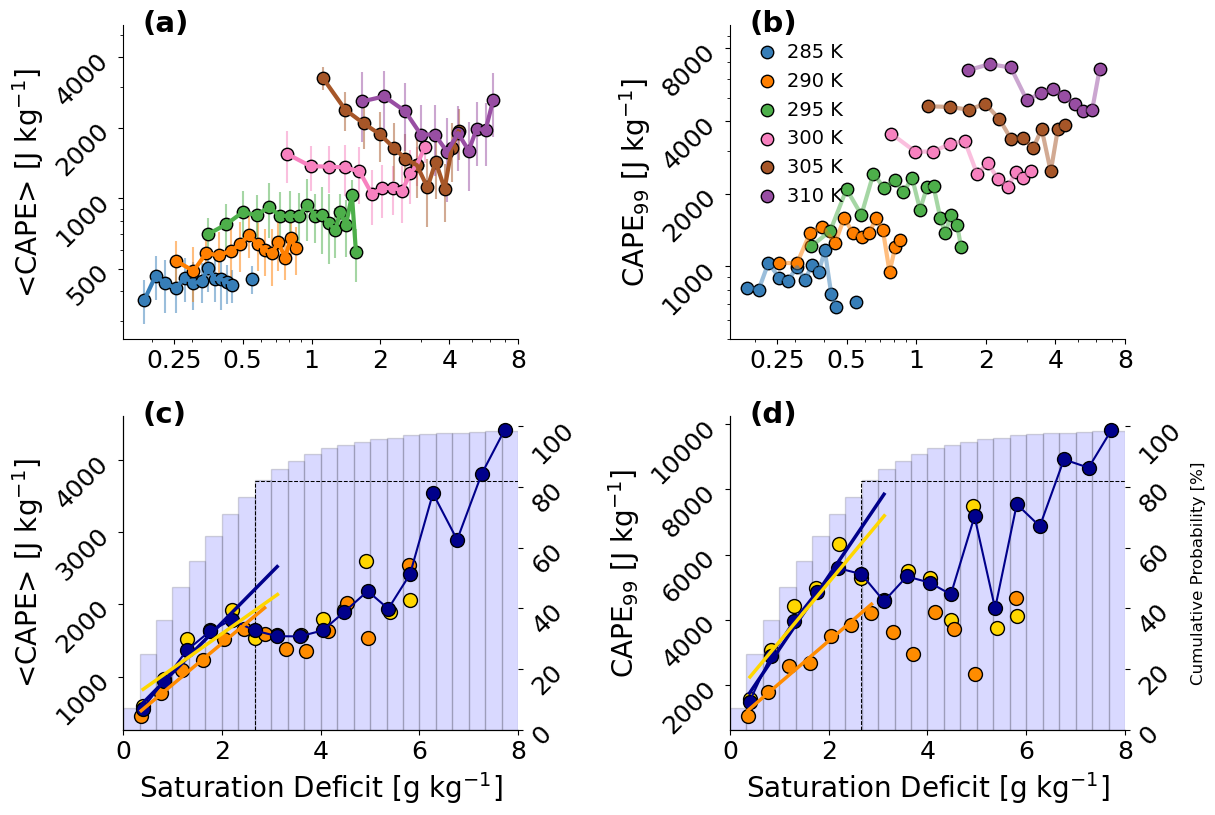

In [68]:
fig, ax = plt.subplots( 2, 2, figsize =(12.5, 8.5) )

ylab = [ r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]', r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]' ]
xlab = [ '', '', r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flatten()): 
    axis.set( ylabel = ylab[i] )
    axis.set( xlabel = xlab[i] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.text( 0.05, 0.98, let[i], transform=axis.transAxes, fontsize=font_size+3, weight='bold' )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    if i == 0:
        for j, k, l, m in zip(sd_bins_list, capemean_list, np.arange(len(sd_bins_list)), capeerror_list):
            axis.plot( j, k, color = CB_color_cycle[l], linewidth=3 )
            axis.scatter( j, k, color = CB_color_cycle[l], s=80, edgecolor='black', label=str(ssts[l])+' K' )
            axis.errorbar( j, k, xerr=None, yerr=m/2, color = CB_color_cycle[l], alpha=0.5, ls='none', zorder=-1 )
        axis.set_xlim([0.15, 8])
        axis.set_ylim([250, 5500])
        axis.set_yscale('log')
        axis.set_xscale('log')
        axis.set_yticks( [500, 1000, 2000, 4000] )
        axis.set_yticklabels( [500, 1000, 2000, 4000] )
        axis.set_xticks( [0.25, 0.5, 1, 2, 4, 8] )
        axis.set_xticklabels( [0.25, 0.5, 1, 2, 4, 8] )
    elif i == 1:
        for j, k, l in zip(sd_bins_list, cape99_list, np.arange(len(sd_bins_list))):
            axis.plot( j, k, color = CB_color_cycle[l], linewidth=3, alpha=0.5 )
            axis.scatter( j, k, color = CB_color_cycle[l], s=80, edgecolor='black', label=str(ssts[l])+' K' )
            
        axis.legend( frameon=False, fontsize=14, loc='upper left', ncol=1, columnspacing=0.4, handletextpad=0.05 )
        axis.set_yscale('log')
        axis.set_xscale('log')
        axis.set_ylim([500, 10000])
        axis.set_xlim([0, 8])
        axis.set_yticks( [1000, 2000, 4000, 8000] )
        axis.set_yticklabels( [1000, 2000, 4000, 8000] )
        axis.set_xticks( [0.25, 0.5, 1, 2, 4, 8] )
        axis.set_xticklabels( [0.25, 0.5, 1, 2, 4, 8] )
    elif i == 2:
        axis.plot( sd_bins_all, capemean_vals_all, color='darkblue' )
        axis.plot( sd_bins_all[:7], out_all.slope*sd_bins_all[:7]+out_all.intercept, color='darkblue', lw=2.5 )
        axis.plot( sd_bins_small[:7], out_small.slope*sd_bins_small[:7]+out_small.intercept, color='gold', lw=2.5 )
        axis.plot( sd_bins_large[:7], out_large.slope*sd_bins_large[:7]+out_large.intercept, color='darkorange', lw=2.5 )
        axis.scatter( sd_bins_small, capemean_vals_small, color='gold', s=100, edgecolor='black'  )
        axis.scatter( sd_bins_large, capemean_vals_large, color='darkorange', s=100, edgecolor='black'  )
        axis.scatter( sd_bins_all, capemean_vals_all, color='darkblue', s=100, edgecolor='black'  )
        wgts = np.ones_like( sd_RCE )/float(len(sd_RCE))*100.
        axis2 = axis.twinx()
        axis.set_zorder(10)
        axis.patch.set_visible(False)
        axis2.spines['top'].set_visible( False )
        axis2.spines['right'].set_visible( False )
        for t in axis2.get_yticklabels():
            t.set_rotation(45)
        axis2.hist( sd_RCE, bins=np.linspace(0,8,25), cumulative=True, alpha=0.15, weights=wgts, color='blue', edgecolor='k' )
        axis.set_xlim([0, 8])
        axis2.set_xlim([0, 8])
        axis2.plot( [2.6633, 8], [82, 82], lw=0.75, ls='--', color='k' )
        axis2.plot( [2.6633, 2.6633], [0, 82], lw=0.75, ls='--', color='k' )
    else:
        axis.plot( sd_bins_all, cape99_vals_all, color='darkblue' )
        axis.plot( sd_bins_all[:7], out_all99.slope*sd_bins_all[:7]+out_all99.intercept, color='darkblue', lw=2.5 )
        axis.plot( sd_bins_small[:7], out_small99.slope*sd_bins_small[:7]+out_small99.intercept, color='gold', lw=2.5 )
        axis.plot( sd_bins_large[:7], out_large99.slope*sd_bins_large[:7]+out_large99.intercept, color='darkorange', lw=2.5 )
        axis.scatter( sd_bins_small, cape99_vals_small, color='gold', s=100, edgecolor='black'  )
        axis.scatter( sd_bins_large, cape99_vals_large, color='darkorange', s=100, edgecolor='black'  )
        axis.scatter( sd_bins_all, cape99_vals_all, color='darkblue', s=100, edgecolor='black'  )
        wgts = np.ones_like( sd_RCE )/float(len(sd_RCE))*100.
        axis2 = axis.twinx()
        axis.set_zorder(10)
        axis.patch.set_visible(False)
        axis2.spines['top'].set_visible( False )
        axis2.spines['right'].set_visible( False )
        axis2.set_ylabel( 'Cumulative Probability [%]', fontsize=12 )
        for t in axis2.get_yticklabels():
            t.set_rotation(45)
        axis2.hist( sd_RCE, bins=np.linspace(0,8,25), cumulative=True, alpha=0.15, weights=wgts, color='blue', edgecolor='k' )
        axis.set_xlim([0, 8])
        axis2.set_xlim([0, 8])
        axis2.plot( [2.6633, 8], [82, 82], lw=0.75, ls='--', color='k' )
        axis2.plot( [2.6633, 2.6633], [0, 82], lw=0.75, ls='--', color='k' )
            
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/sd-cape-RCE-percentiles.pdf', bbox_inches='tight' )
plt.show()